# Predicting Hospital Readmissions in Diabetic Patients: A Machine Learning Approach

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

## Introduction

Diabetes is a chronic metabolic disorder affecting millions of people worldwide, posing significant challenges to global healthcare systems. It requires continuous medical care and patient self-management education to prevent acute complications and to reduce the risk of long-term complications. Hospital readmissions among diabetic patients represent a substantial portion of healthcare costs and often indicate gaps in the effective management of the condition. Addressing these readmissions is crucial for improving patient outcomes and reducing the economic burden on healthcare systems.

## Problem Statement

Hospital readmissions for diabetic patients not only contribute to increased healthcare costs but also reflect potential shortcomings in patient care and disease management. Particularly, readmissions occurring within 30 days of discharge are considered preventable and are associated with inadequate treatment or management plans. The ability to predict these readmissions accurately can enable healthcare providers to implement targeted interventions, thus improving patient care and reducing unnecessary costs.

## Objectives

The primary objectives of this project are:

- **Develop a Predictive Model**: To create a two-step binary classification algorithm capable of predicting hospital readmissions among diabetic patients. The first step aims to predict the likelihood of readmission, and the second step focuses on distinguishing early readmissions (within 30 days) from late readmissions (after 30 days).

- **Optimize Model Performance**: To focus on optimizing AUC-ROC scores and recall metrics to ensure the model accurately identifies true positives, particularly early readmissions, which are more critical for patient care and cost reduction.

- **Impact Analysis**: To assess the potential impact of the predictive model on reducing direct healthcare costs associated with readmissions and enhancing patient care through more personalized and preventive actions.

- **Future Enhancements**: To identify areas for future improvements and additional data collection that could refine the model's predictions and extend its applicability and effectiveness in real-world settings.

## Exploratory Data Analysis

First we try to understand what kind of data we have, including how many rows, features and a first look into the distribution of our target variable. For features descriptions we used the official data dictionary from https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In [2]:
df = pd.read_csv(r'../data/raw/diabetic_readmission_data.csv')
print(f'The number of rows in the data is {df.shape[0]}')
print(f'The number of columns is {df.shape[1]}')

The number of rows in the data is 101766
The number of columns is 50


The next step is to understand the data types we are dealing with

In [3]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

encounter_id and patient_nbr are identifiers so we set them as strings.
admission_type_id, discharge_disposition_id and admission_source_id are actually categorical features
Source: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In [4]:
df[['encounter_id', 'patient_nbr']] = df[['encounter_id', 'patient_nbr']].astype(str)
print(f'The number of encounters in the data is {df["encounter_id"].nunique()}')
print(f'The number of patients in the data is {df["patient_nbr"].nunique()}')

The number of encounters in the data is 101766
The number of patients in the data is 71518


In [5]:
num = df[(df['readmitted'] != 'NO')]['encounter_id'].nunique()
den = df[(df['readmitted'] != 'NO')]['patient_nbr'].nunique()
num / den

1.6294469149527515

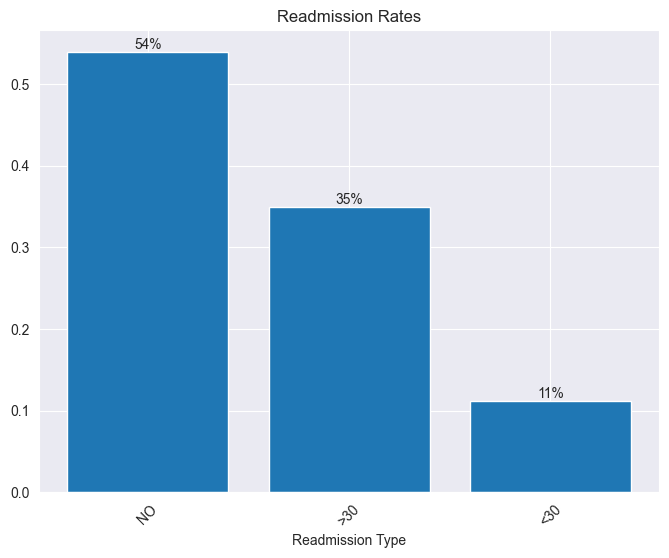

In [6]:
target_distribution= df['readmitted'].value_counts(normalize=True)
#Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(target_distribution.index, target_distribution.values)

# Adding value labels on each bar, formatted as percentages
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval * 100)}%', ha='center', va='bottom')

plt.title('Readmission Rates')
plt.xlabel('Readmission Type')
plt.ylabel('')
plt.xticks(rotation=45)
plt.show()

## Descriptive Statistics

Descriptive statistics of the dataset give us sense of how the data behaves.

In [7]:
df.describe(include = 'all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,101766,71518,6,3,10,10,NaN,NaN,NaN,NaN,...,1,4,4,2,2,2,2,2,2,3
top,2278392,88785891,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,1,40,76099,54708,26068,98569,NaN,NaN,NaN,NaN,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Numerical Columns Distributions

In [8]:
num_df = df.select_dtypes(include = ['number'])

#Removing already encoded columns from numeric column types analyses
num_df.drop(['admission_type_id',
             'discharge_disposition_id',
             'admission_source_id'], axis = 1,inplace = True)
num_df.shape

(101766, 8)

In order to improve our sense of numeric features we plot histograms

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')


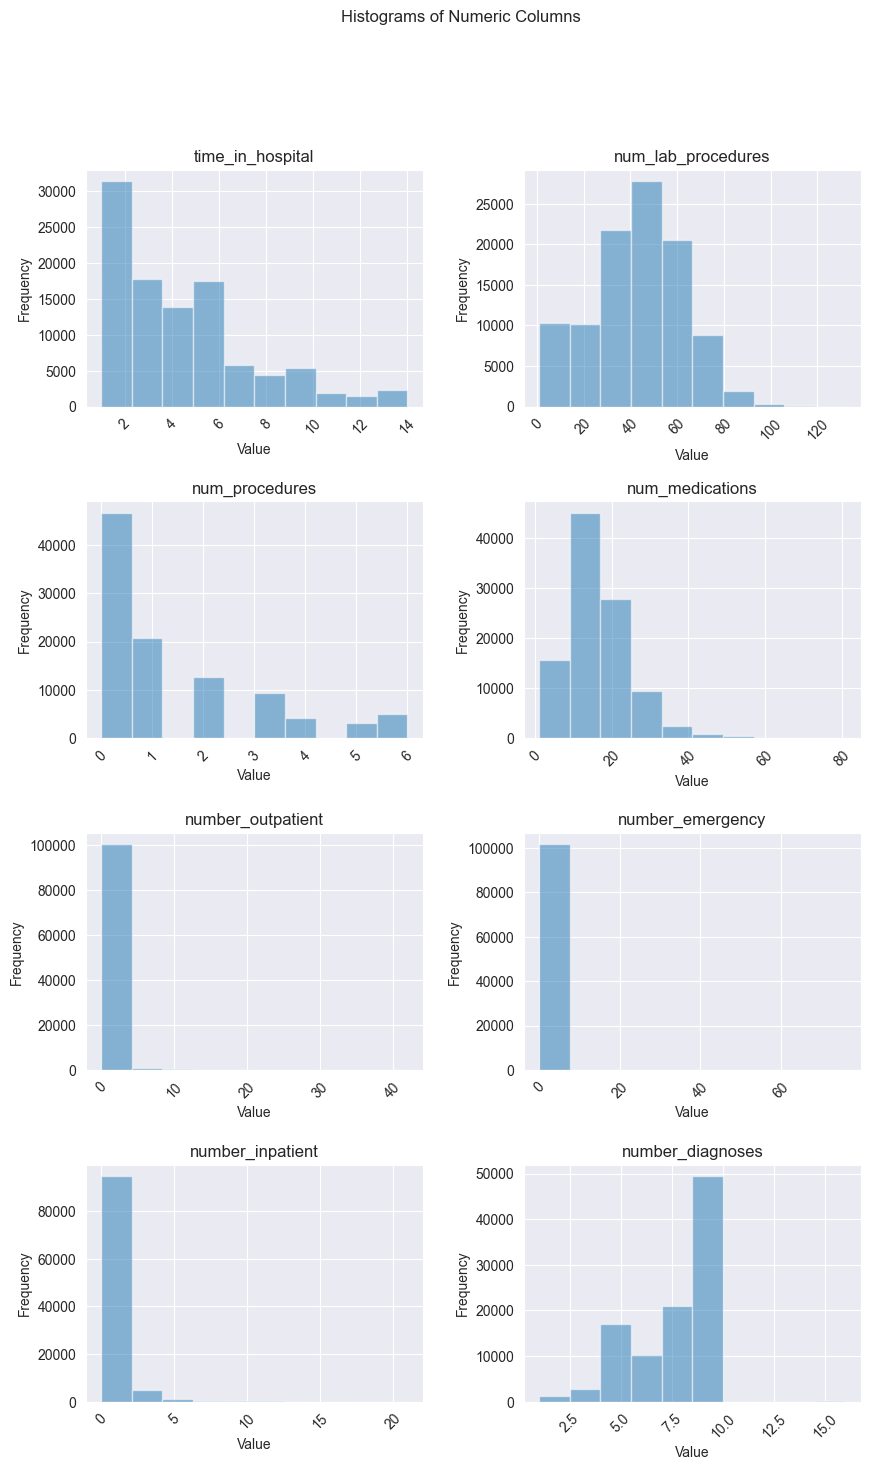

In [9]:
print(num_df.columns)
num_columns = num_df.columns
n_cols = 2 
n_rows = (len(num_columns) + 1) // n_cols 

plt.figure(figsize=(10, 4 * n_rows)) 
for i, column in enumerate(num_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    num_df[column].hist(alpha=0.5, bins=10)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('Histograms of Numeric Columns')
plt.show()

We start looking for relations between these columns and our target "readmitted" as well:

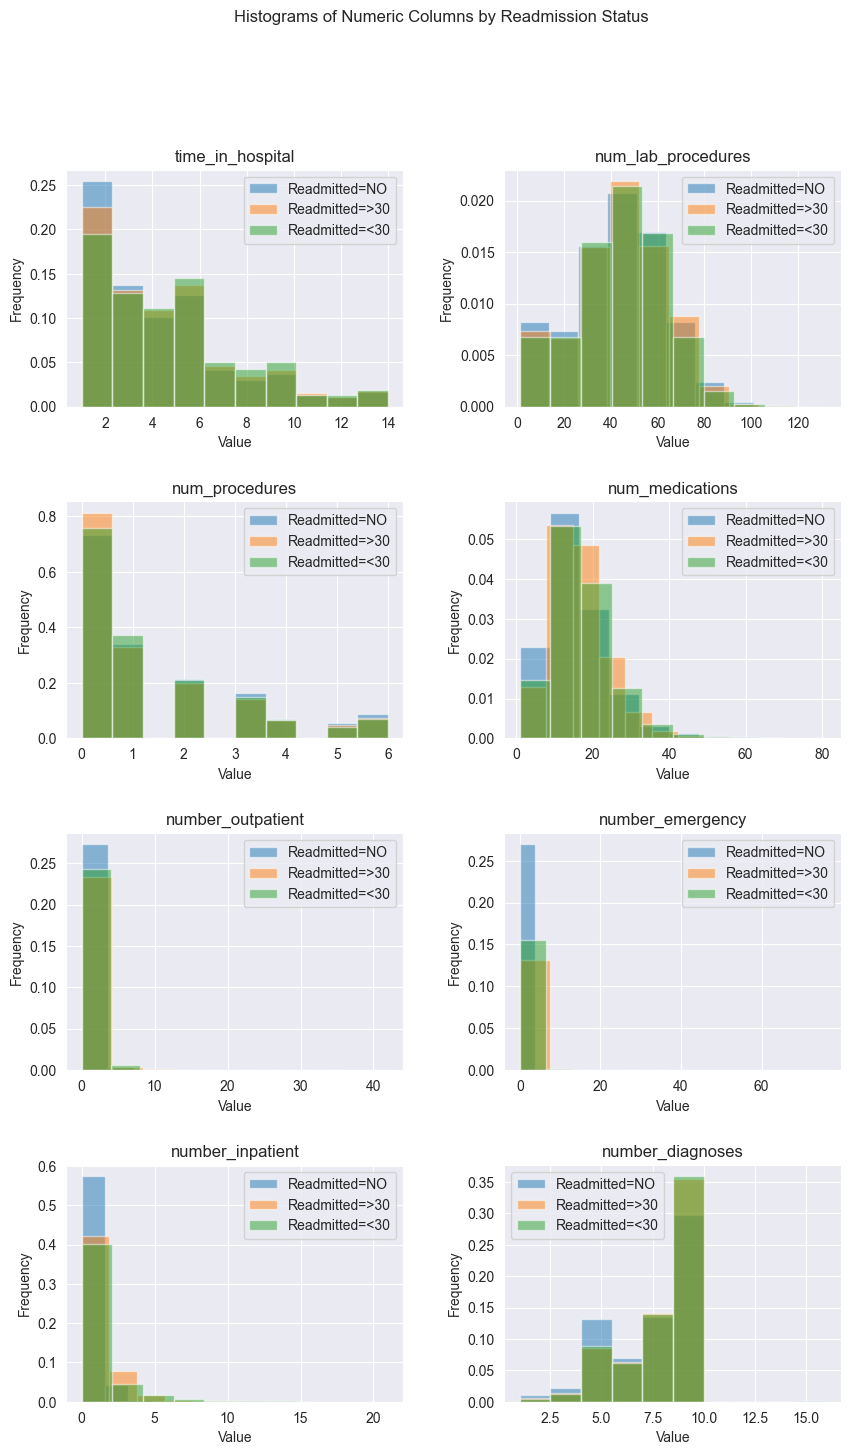

In [10]:
#Plot histograms differentiating by target label
num_columns = num_df.columns  # Exclude the target column 'readmitted'
n_cols = 2
n_rows = len(num_columns) // n_cols if len(num_columns) % n_cols == 0 else (len(num_columns) // n_cols) + 1

plt.figure(figsize=(10, 4 * n_rows))

for i, column in enumerate(num_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    # Plot histograms for each category of the 'readmitted' column
    for readmitted_status in df['readmitted'].unique():
        subset = df[df['readmitted'] == readmitted_status]
        subset[column].hist(alpha=0.5, bins=10, density=True,label=f'Readmitted={readmitted_status}')
    
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('Histograms of Numeric Columns by Readmission Status')
plt.show()

## Categorical columns distributions

Here we analyze the distinct values that categorical features can take and its weight within the column

In [11]:
cat_columns = ['race',
               'gender',
               'age',
               'weight',
               'admission_type_id',
               'discharge_disposition_id',
               'admission_source_id',
               'payer_code',
               'medical_specialty',
               'max_glu_serum',
               'A1Cresult',
               'change',
               'diabetesMed']

for i in cat_columns:
    print(df[i].value_counts(normalize = True))

race
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: proportion, dtype: float64
gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: proportion, dtype: float64
age
[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: proportion, dtype: float64
weight
?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: proportion, dtype: float64
admission_type_id
1    0.530531
3    0.185416
2    0.181593
6    0.051992
5    0.047020
8    0.003144
7    0.000206
4    0.000098
Name: proportion, dtype: float64


Now we try to spot visually possible relations between some of the categorical features with the readmission rates:

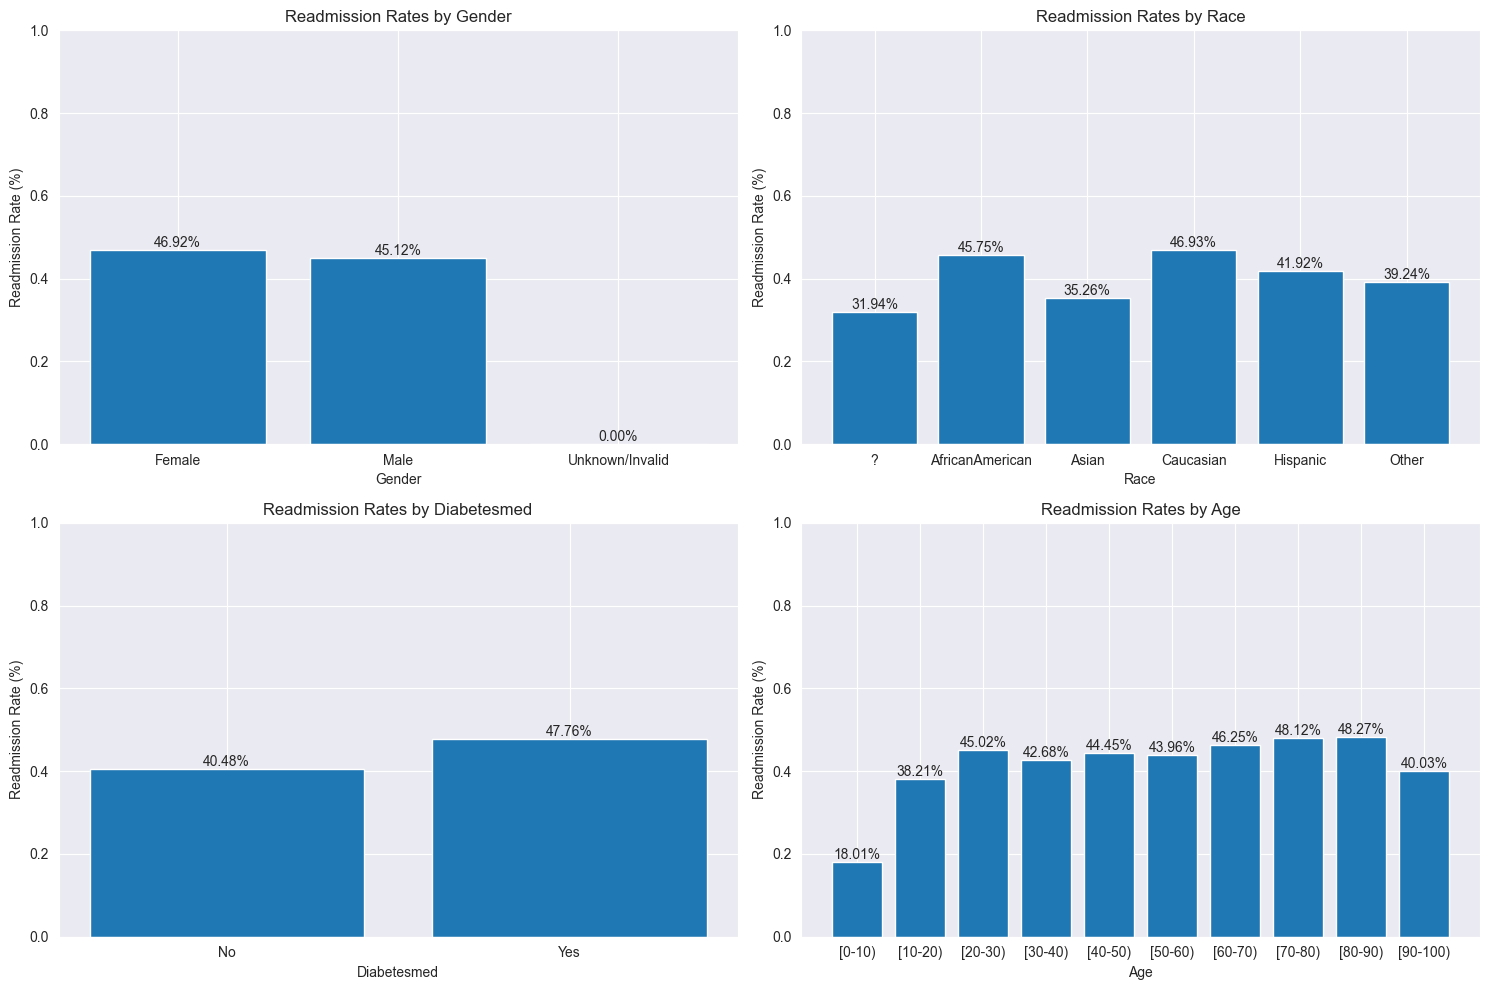

In [12]:
df['readmitted_general'] = np.where(df['readmitted']== 'NO',0,1)
cat_to_plot = ['gender', 'race', 'diabetesMed', 'age']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, cat in enumerate(cat_to_plot):
    # Calculate the mean readmission rate for each category
    category_means = df.groupby(cat)['readmitted_general'].mean()
    # Plotting the bar plot
    axes[i].bar(category_means.index, category_means.values)
    axes[i].set_title(f'Readmission Rates by {cat.title()}')
    axes[i].set_xlabel(cat.title())
    axes[i].set_ylabel('Readmission Rate (%)')
    axes[i].set_ylim(0, 1)
    # Adding percentage labels on each bar
    for index, value in enumerate(category_means.values):
        axes[i].text(index, value, f'{value:.2%}', ha="center", va='bottom')

plt.tight_layout()
plt.show()

# Missing values

This section spots missing values within each feature in order to start thinking about its manipulation strategy

In [13]:
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [14]:
(df == '?').sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Missing values are denoted with the '?' character

## Outliers detection

Here we use boxplots to identify the presence of outliers or not in numerical features. Treatment of outliers and missing values comes in the Data manipulation section

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')


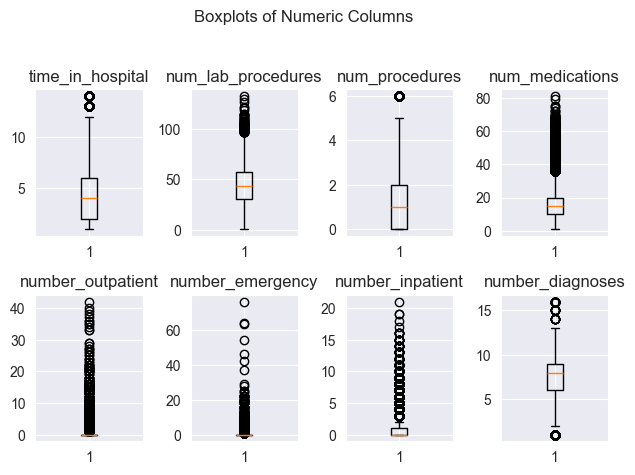

In [15]:
print(num_df.columns)
fig, axes = plt.subplots(2, 4) 

axes_flat = axes.flatten()

for ax, column in zip(axes_flat, num_df.columns):
    ax.boxplot(num_df[column])
    ax.set_title(column)

plt.suptitle('Boxplots of Numeric Columns')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Data Manipulation

This section is about the treatment of missing values, outliers and categorical features (encoding)

## Missing values

In [16]:
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [17]:
(df == '?').sum() / df.shape[0]

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
c

Missing values in max_glu_serum and A1Cresult are not realy missing values. Not measured was reported as None which is automatically a missing value for pandas library.
source: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In [18]:
df.fillna({'max_glu_serum': 'Not measured',
           'A1Cresult': 'Not measured'}, inplace=True)
df.isna().sum().value_counts()

0    51
Name: count, dtype: int64

weight and payer_code were removed due to the high percentage of missing values and the low explainability they may have with readmissions

In [19]:
df.drop(['weight', 'payer_code'], axis = 1, inplace=True)

In [20]:
df['race'].value_counts(normalize=True)

race
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: proportion, dtype: float64

medical_specialty missing values are considered as a new category as it may be an informative feature for the target variable. This also happened with primary diagnosis and secondary diagnoses (missingness was replaced by "Missing")

In the case of race, as missing values were approximately 2% of the values they were added to "Other"

In [21]:
df[['medical_specialty',
    'diag_1',
    'diag_2',
    'diag_3']] = df[['medical_specialty',
                     'diag_1',
                     'diag_2',
                     'diag_3']].apply(lambda x: x.str.replace('?', 'Missing'), axis = 1)

df['race'] = df['race'].str.replace('?', 'Other')
df = df.loc[(df['gender'] != 'Unknown/Invalid'),:]

In [22]:
(df == '?').sum() / df.shape[0]

encounter_id                0.0
patient_nbr                 0.0
race                        0.0
gender                      0.0
age                         0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
medical_specialty           0.0
num_lab_procedures          0.0
num_procedures              0.0
num_medications             0.0
number_outpatient           0.0
number_emergency            0.0
number_inpatient            0.0
diag_1                      0.0
diag_2                      0.0
diag_3                      0.0
number_diagnoses            0.0
max_glu_serum               0.0
A1Cresult                   0.0
metformin                   0.0
repaglinide                 0.0
nateglinide                 0.0
chlorpropamide              0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglita

## Outliers

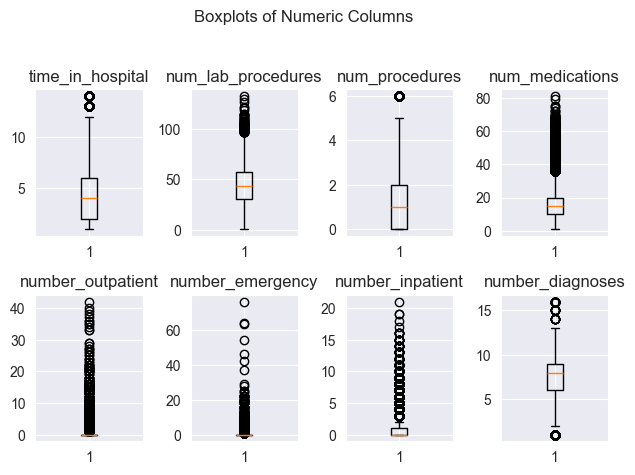

In [23]:
cat_columns = list(df.select_dtypes(object).columns)
cat_columns.extend(['admission_type_id',
                    'discharge_disposition_id',
                    'admission_source_id'])
df[cat_columns] = df[cat_columns].astype('category')
num_columns = list(df.select_dtypes(include = ['number']).columns)
num_df = df[num_columns]
fig, axes = plt.subplots(2, 4)

axes_flat = axes.flatten()

for ax, column in zip(axes_flat, num_df.columns):
    ax.boxplot(num_df[column])
    ax.set_title(column)

plt.suptitle('Boxplots of Numeric Columns')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

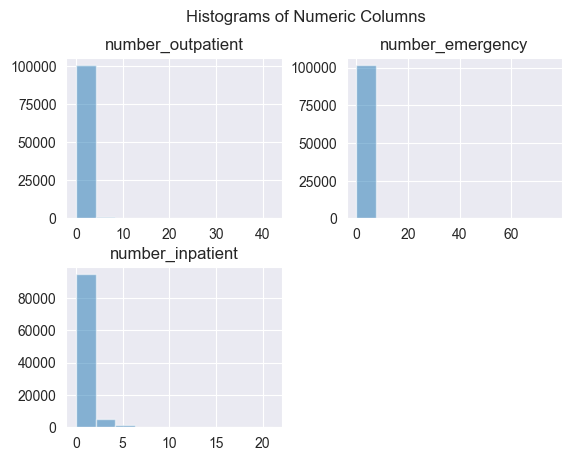

In [24]:
df[['number_outpatient',
    'number_emergency',
    'number_inpatient']].hist(alpha=0.5, bins=10)
plt.suptitle('Histograms of Numeric Columns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Outliers were removed with IQR method using alpha = 1.5
Due to the distribution of number_outpatient, number_impatient and number_emergency it doesn't make sense to disregard outliers with the IQR method

In [25]:
no_iqr_considered = ['number_outpatient',
                     'number_emergency',
                     'number_inpatient']
quantiles = df[num_columns]\
    .drop(no_iqr_considered, axis = 1)\
    .quantile([0.25,0.75])
quantiles

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted_general
0.25,2.0,31.0,0.0,10.0,6.0,0.0
0.75,6.0,57.0,2.0,20.0,9.0,1.0


In [26]:
IQR = quantiles.loc[0.75] - quantiles.loc[0.25]
IQR

time_in_hospital       4.0
num_lab_procedures    26.0
num_procedures         2.0
num_medications       10.0
number_diagnoses       3.0
readmitted_general     1.0
dtype: float64

In [27]:
print(f'Rows before removing outliers: {df.shape[0]}')
for i in quantiles.columns:
    df[i] = df[i].where(
        (df[i] <= quantiles[i][0.75] + IQR[i]*1.5) &
        (df[i] >= quantiles[i][0.25] - IQR[i]*1.5)
    )

df.dropna(inplace=True)
print(f'Rows after removing outliers: {df.shape[0]}')

Rows before removing outliers: 101763
Rows after removing outliers: 93075


## Categorical features (encoding)

Target variable was encoded ordinally with 0 being not readmitted, 1 being readmitted within the first month and 2 afterwards. After several tries, due to the imbalanced nature of the data, we found the best performing algorithm by training two models: one model   to predict whether the patient will be readmitted or not and the second one is going to predict if the readmission will be before or after the 30 days. For this we use the already created new target for the first model "readmitted_general".

In [28]:
#Target variable
encode = {'NO': 0,
          '<30': 1,
          '>30': 2}

df['readmitted'] = df['readmitted'].map(encode)
df['readmitted'] = df['readmitted'].astype(int)

Features with two distinct values such as diabetesMed and change (basically "Yes" and "No") were binary encoded: "Yes" = 1 and "No" = 0

In [29]:
#diabetesMed variable
encode = {'No': 0,
          'Yes': 1}

df['diabetesMed'] = df['diabetesMed'].replace(encode)

#change variable
encode = {'No': 0,
          'Ch': 1}

df['change'] = df['change'].replace(encode)

#gender variable
encode = {'Male': 0,
          'Female': 1}

df['gender'] = df['gender'].replace(encode)

/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/61034405.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diabetesMed'] = df['diabetesMed'].replace(encode)
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/61034405.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['diabetesMed'] = df['diabetesMed'].replace(encode)
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/61034405.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain t

We think that medical_specialty is actually informative for our target variables; nevertheless, by having too many missing values and  values with too low frequency we elected to transform it into a binary one in which 0 means missing and 1 not missing

In [30]:
df['medical_specialty'].value_counts(normalize=True)

medical_specialty
Missing                             0.492109
InternalMedicine                    0.148482
Emergency/Trauma                    0.076712
Family/GeneralPractice              0.075638
Cardiology                          0.045984
                                      ...   
Proctology                          0.000011
Surgery-PlasticwithinHeadandNeck    0.000011
Neurophysiology                     0.000011
Perinatology                        0.000011
Pediatrics-InfectiousDiseases       0.000011
Name: proportion, Length: 73, dtype: float64

In [31]:
df['medical_specialty'] = np.where(df['medical_specialty'] == 'Missing',0,1)

For diag_1, diag_2 and diag_3 we tried three ways: embeddings with co-ocurrence matrix, the replication of a study on the HbA1c measurement impact in readmissions rate which classifies by types of disease group (https://www.hindawi.com/journals/bmri/2014/781670/tab2/>), and the best-performing one that which utilized TfidVectorizer from scikit-learn, which is commonly applied to encode text given the importance of its words within certain document or dataset. Less common words are weighted higher as they may be more differentiated than the most common ones. The way we used it for the diagnoses was to treat the three columns as a concatenated text and then apply the vectorizer to weight each diagnosis code based on how common it is among all its possible combinations. The result is a vector for each row with the number of unique codes that we have in our data (≈900). Then we applied PCA to these features and we were able to reduce the features to ≈100.

### Embeddings

The number of components where cumulative variance is above 0.75: 104


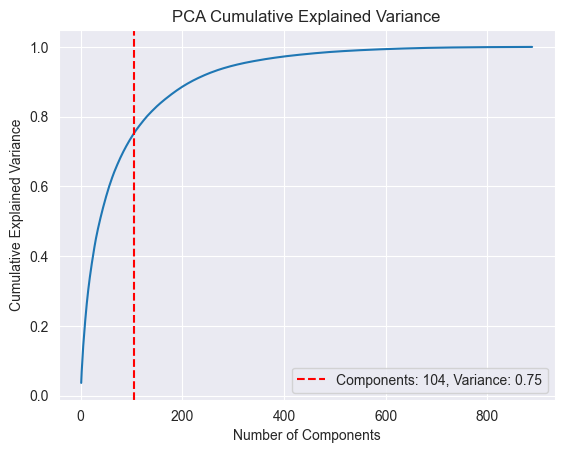

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
df['concat_diags'] = df['diag_1'].str.cat(df['diag_2'].str.cat(df['diag_3'], sep = ' '), sep=' ')
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['concat_diags'])

dense_tfidf_features = tfidf_features.toarray()  # or tfidf_features.todense()
pca = PCA()
pca.fit(dense_tfidf_features)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_above_75 = np.argmax(cumulative_variance >= 0.75) + 1
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)

# Highlight the point where cumulative variance exceeds 0.75
if num_components_above_75 > 0:
    plt.axvline(x=num_components_above_75, color='r', linestyle='--', label=f'Components: {num_components_above_75}, Variance: {cumulative_variance[num_components_above_75-1]:.2f}')
    plt.legend()
    
    
print(f"The number of components where cumulative variance is above 0.75: {num_components_above_75}")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')

plt.show()


In [33]:
pca = PCA(n_components=num_components_above_75)
embeddings = pca.fit_transform(dense_tfidf_features)
pca_columns = [f'diag_pca_{i+1}' for i in range(embeddings.shape[1])]

pca_df = pd.DataFrame(embeddings, columns=pca_columns)
df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)
df.drop(['diag_1',
         'diag_2',
         'diag_3',
         'concat_diags'], axis=1, inplace=True)

df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_pca_95,diag_pca_96,diag_pca_97,diag_pca_98,diag_pca_99,diag_pca_100,diag_pca_101,diag_pca_102,diag_pca_103,diag_pca_104
0,149190,55629189,Caucasian,1,[10-20),1,1,7,3.0,0,...,0.003687,0.004773,-0.002857,0.020591,0.006494,-0.013470,0.005429,0.013112,0.006366,-0.001542
1,64410,86047875,AfricanAmerican,1,[20-30),1,1,7,2.0,0,...,-0.048872,-0.067696,-0.014503,-0.075527,-0.055196,0.021157,-0.025424,-0.132932,-0.005834,0.020638
2,500364,82442376,Caucasian,0,[30-40),1,1,7,2.0,0,...,0.007672,0.000961,-0.009491,0.011093,0.008045,-0.007931,0.014388,-0.007806,0.004589,0.011397
3,16680,42519267,Caucasian,0,[40-50),1,1,7,1.0,0,...,0.000637,-0.022791,0.001162,-0.019169,0.010366,-0.019140,0.000803,-0.017776,0.016022,0.023154
4,55842,84259809,Caucasian,0,[60-70),3,1,2,4.0,0,...,-0.002217,-0.003957,-0.000745,-0.002066,-0.004999,0.000770,-0.012174,0.003718,0.005254,0.002304


age feature, as it has a natural logical order will be encoded using ordinal encoder

In [34]:
df.sort_values(by=['age'])['age'].unique()

['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
Categories (10, object): ['[0-10)', '[10-20)', '[20-30)', '[30-40)', ..., '[60-70)', '[70-80)', '[80-90)', '[90-100)']

In [35]:
from sklearn.preprocessing import OrdinalEncoder
age_orders = [sorted(df['age'].unique())]
ordinal_encoder = OrdinalEncoder(categories=age_orders)
df['age'] = ordinal_encoder.fit_transform(df[['age']])

Drug features (from metformin to metformin-pioglitazone) are more complex because each of them could take 4 possible values (up, down, steady and No). Additionally, there are drugs that are less common in patients and that we do not have examples of all possible values among this "rare" drug usage. These cases are clearer when we see the values they take, and we recognize an imbalance towards non-usage. This feature will only be noisy and won´t add information for the model, thus we discard them

In [36]:
drugs = ['metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
drugs_val_count = dict()
for i in drugs:
    n = df[i].nunique()
    drugs_val_count[i] = n
    
drop_drugs=[]
for key, value in drugs_val_count.items():
    if value < 4:
        drop_drugs.append(key)
        print(df[key].value_counts(normalize=True))

df.drop(drop_drugs, axis=1,inplace=True)

acetohexamide
No        1.0
Steady    0.0
Name: proportion, dtype: float64
tolbutamide
No        0.999785
Steady    0.000215
Name: proportion, dtype: float64
troglitazone
No        0.999968
Steady    0.000032
Name: proportion, dtype: float64
tolazamide
No        0.999592
Steady    0.000398
Up        0.000011
Name: proportion, dtype: float64
examide
No    1.0
Name: proportion, dtype: float64
citoglipton
No    1.0
Name: proportion, dtype: float64
glipizide-metformin
No        0.99986
Steady    0.00014
Name: proportion, dtype: float64
glimepiride-pioglitazone
No        0.999989
Steady    0.000011
Name: proportion, dtype: float64
metformin-rosiglitazone
No        0.999989
Steady    0.000011
Name: proportion, dtype: float64
metformin-pioglitazone
No        0.999989
Steady    0.000011
Name: proportion, dtype: float64


We have already encoded age, gender, medical_specialty, change and diabetesMed. admission_type_id, discharge_disposition_id and admission_source_id are already encoded so they do not need further manipulation. The encoding strategy for the rest of features will be based on the number of values each feature can take and of course the type of feature it is

In [37]:
df.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace=True)

num_columns = ['time_in_hospital', 
               'num_lab_procedures', 
               'num_procedures',
               'num_medications', 
               'number_outpatient', 
               'number_emergency',
               'number_inpatient', 
               'number_diagnoses']
diag_pca_columns = [col for col in df.columns if col.startswith('diag_pca')]
num_columns.extend(diag_pca_columns)
cat_columns = df.drop(num_columns,axis=1).columns
cat_columns_to_encode=df[cat_columns].drop(['age',
                                            'gender',
                                            'change',
                                            'medical_specialty',
                                            'diabetesMed',
                                            'admission_type_id',
                                            'discharge_disposition_id',
                                            'admission_source_id',
                                            'readmitted',
                                            'readmitted_general'], axis=1).columns

print(f'Features pending to encode: {cat_columns_to_encode}')

Features pending to encode: Index(['race', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'insulin', 'glyburide-metformin'],
      dtype='object')


We define the threshold of 4 maximum possible values in each feature to be one-hot encoded, if the number of labels is greater then we use impact encoding.

In [38]:
one_hot_columns=[]
impact_encode_columns=[]
for i in cat_columns_to_encode:
    n = df[i].nunique()
    if n <=4:
        one_hot_columns.append(i)
    else:
        impact_encode_columns.append(i)
        
print(one_hot_columns)
print(impact_encode_columns)

['max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin']
['race']


In [39]:
#One hot encoding
df = pd.get_dummies(df, columns=one_hot_columns)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Steady,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up
0,Caucasian,1,1.0,1,1,7,3.0,0,59.0,0.0,...,False,False,False,False,False,True,False,True,False,False
1,AfricanAmerican,1,2.0,1,1,7,2.0,0,11.0,5.0,...,False,False,False,True,False,False,False,True,False,False
2,Caucasian,0,3.0,1,1,7,2.0,0,44.0,1.0,...,False,False,False,False,False,True,False,True,False,False
3,Caucasian,0,4.0,1,1,7,1.0,0,51.0,0.0,...,False,False,False,False,True,False,False,True,False,False
4,Caucasian,0,6.0,3,1,2,4.0,0,70.0,1.0,...,False,False,False,False,True,False,False,True,False,False


Train/test split must be done before applying impact encoding as the values that will be mapped to the categorical features can only be computed with training labels. We also have to separate the data that will be used for the readmission type model (<30 or >30) as the features depend on the target and this "submodel" target is different from the general one (readmission or no readmission).

In [40]:
encode = {2: 0,
          1: 1}
df['readmitted_type'] = df['readmitted'].map(encode)
df['readmitted_type'] = df['readmitted_type'].astype('Int64')

**Train/test split**</br>

The selected training size is 85% vs 15% for testing. The test set will be only used for **final predictions**, i.e. the final predicted label (3 classess). Additional splits are performed within the training set for the two individual models.

In [41]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df.copy(), train_size = 0.85, random_state=7)
train_model1, test_model1 = train_test_split(train, train_size = 0.9, random_state=7)
train_readmission = train[(train['readmitted_general'] == 1)]
train_model2, test_model2 = train_test_split(train_readmission, train_size = 0.8, random_state=7)
print(f'Overall train size = {train.shape[0]}')
print(f'Overall test size = {test.shape[0]}')
print(f'Train size for  Readmission vs No Readmission model = {train_model1.shape[0]}')
print(f'Test size for Readmission vs No Readmission model = {test_model1.shape[0]}')
print(f'Train size for Type of Readmission model = {train_model2.shape[0]}')
print(f'Test size for Type of Readmission model = {test_model2.shape[0]}')

Overall train size = 79113
Overall test size = 13962
Train size for  Readmission vs No Readmission model = 71201
Test size for Readmission vs No Readmission model = 7912
Train size for Type of Readmission model = 29378
Test size for Type of Readmission model = 7345


In [42]:
train_model1_wo_impact_encoding = train_model1.copy()
train_model2_wo_impact_encoding = train_model2.copy()
def impact_encoding_model1(dataframe):
    for i in impact_encode_columns:
        encodings = train_model1_wo_impact_encoding.groupby([i])['readmitted_general'].mean()
        dataframe[i] = dataframe[i].map(encodings)

def impact_encoding_model2(dataframe):
    for i in impact_encode_columns:
        encodings = train_model2_wo_impact_encoding.groupby([i])['readmitted_type'].mean()
        dataframe[i] = dataframe[i].map(encodings)
        
for dframe in [train_model1, test_model1]:
    impact_encoding_model1(dframe)
    
for dframe in [train_model2, test_model2]:
    impact_encoding_model1(dframe)

#for i in impact_encode_columns:
 #   group_df1 = train_model1.groupby([i])['readmitted_general'].mean()
  #  train_model1[i] = train_model1[i].map(group_df1)
   # test_model1[i] = test_model1[i].map(group_df1)
    #group_df2 = train_model2.groupby([i])['readmitted_type'].mean()
    #train_model2[i] = train_model2[i].map(group_df2)
    #test_model2[i] = test_model2[i].map(group_df2)
    

/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/4233579887.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encodings = train_model1_wo_impact_encoding.groupby([i])['readmitted_general'].mean()
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/4233579887.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encodings = train_model1_wo_impact_encoding.groupby([i])['readmitted_general'].mean()
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/4233579887.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of

In [43]:
train_model2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,readmitted_type
61989,0.458486,1,8.0,1,6,7,6.0,0,63.0,0.0,...,False,False,False,True,False,False,True,False,False,0
60974,0.473351,1,8.0,2,3,7,6.0,1,64.0,0.0,...,False,False,False,False,True,False,True,False,False,0
84674,0.473351,0,7.0,1,3,7,5.0,0,58.0,0.0,...,False,False,False,True,False,False,True,False,False,0
62790,0.473351,0,6.0,5,3,1,3.0,0,14.0,2.0,...,False,False,False,False,True,False,True,False,False,0
16394,0.473351,0,7.0,1,18,7,3.0,0,42.0,0.0,...,False,False,True,False,False,False,True,False,False,1


## Feature Scaling
Standard scaler was done for both models datasets

In [44]:
from sklearn.preprocessing import StandardScaler

#We drop the readmitted columns that have nothing to do with each model
train_model1.drop(['readmitted','readmitted_type'], axis=1,inplace=True)
test_model1.drop(['readmitted','readmitted_type'], axis=1,inplace=True)
train_model2.drop(['readmitted','readmitted_general'], axis=1,inplace=True)
test_model2.drop(['readmitted','readmitted_general'], axis=1,inplace=True)

# Target variables are not scaled
no_scale_model1 = ['readmitted_general']
no_scale_model2 = ['readmitted_type']

#Defining feature columns
features_model1 = train_model1.drop(no_scale_model1, axis=1).columns
features_model2 = train_model2.drop(no_scale_model2, axis=1).columns

#Defining scalers
scaler1 = StandardScaler()
scaler2 = StandardScaler()

#Fitting scalers
scaler1.fit(train_model1[features_model1])
scaler2.fit(train_model2[features_model2])

#Applying scalers
train_model1_scaled = scaler1.transform(train_model1[features_model1])
test_model1_scaled = scaler1.transform(test_model1[features_model1])
train_model2_scaled = scaler2.transform(train_model2[features_model2])
test_model2_scaled = scaler2.transform(test_model2[features_model2])

#Returning to dfs
train_model1_scaled = pd.DataFrame(train_model1_scaled, columns=features_model1)
test_model1_scaled = pd.DataFrame(test_model1_scaled, columns=features_model1)
train_model2_scaled = pd.DataFrame(train_model2_scaled, columns=features_model2)
test_model2_scaled = pd.DataFrame(test_model2_scaled, columns=features_model2)

# Assign the values from the original DataFrames targets
# And explicitly set the data type to match the original DataFrames

for col in no_scale_model1:
    train_model1_scaled[col] = train_model1[col].values.astype(train_model1[col].dtype)
    test_model1_scaled[col] = test_model1[col].values.astype(test_model1[col].dtype)
    
for col in no_scale_model2:
    train_model2_scaled[col] = train_model2[col].values.astype(train_model2[col].dtype)
    test_model2_scaled[col] = test_model2[col].values.astype(test_model2[col].dtype)

# Model 1 (No Readmission vs Readmission)

### Feature Selection

The first method we tried to select features was to find linear correlations between the variables and our target variable

In [45]:
import seaborn as sns

#Creating the correlaton matrix
correlation_matrix_model1 = train_model1.corr()
correlation_matrix_model2 = train_model2.corr()

#Focusing on correlations with our targets
correlations_with_readmission = correlation_matrix_model1['readmitted_general']
correlations_with_readmission_type= correlation_matrix_model2['readmitted_type']

#Sorting the correlations by the absolut value in descending order
sorted_correlations_with_readmission = correlations_with_readmission.abs().sort_values(ascending=False)
sorted_correlations_with_readmission_type = correlations_with_readmission_type.abs().sort_values(ascending=False)

#Looking for |correlations| > 0.5
print(sorted_correlations_with_readmission[sorted_correlations_with_readmission >=.5])
print(sorted_correlations_with_readmission_type[sorted_correlations_with_readmission_type >=.5])

readmitted_general    1.0
Name: readmitted_general, dtype: float64
readmitted_type    1.0
Name: readmitted_type, dtype: float64


We realized that there are not linear correlations between our features and our targets, which means that we need another feature selection strategy (non-linear way)

**Linear correlations between features**</br>

We also look for correlations between features as it may affect the models performance

**Correlations between features for general readmission model**

In [46]:
# Define the threshold for filtering
threshold = 0.6

# Create a mask to ignore self-correlation, converting DataFrame to numpy array first
mask = np.abs(correlation_matrix_model1.values) >  threshold  # Use .values to get numpy array
np.fill_diagonal(mask, False)

# Apply mask to find high correlations, convert mask back to DataFrame for where() operation
high_corr_pairs_model1 = correlation_matrix_model1.where(pd.DataFrame(mask, index=correlation_matrix_model1.index, columns=correlation_matrix_model1.columns))

# Stack the DataFrame and reset index to get pairings
stacked = high_corr_pairs_model1.stack().reset_index()
stacked.columns = ['Feature1', 'Feature2', 'Correlation']

# Filter out lower triangle to avoid duplicates
filtered_pairs_model1 = stacked[stacked['Feature1'] < stacked['Feature2']]

print(filtered_pairs_model1)

                  Feature1                    Feature2  Correlation
0       max_glu_serum_Norm  max_glu_serum_Not measured    -0.694019
2             A1Cresult_>8      A1Cresult_Not measured    -0.660388
4             metformin_No            metformin_Steady    -0.950383
6           repaglinide_No          repaglinide_Steady    -0.948736
8           nateglinide_No          nateglinide_Steady    -0.970203
10       chlorpropamide_No       chlorpropamide_Steady    -0.964874
12          glimepiride_No          glimepiride_Steady    -0.948125
14            glipizide_No            glipizide_Steady    -0.943933
16            glyburide_No            glyburide_Steady    -0.927604
18         pioglitazone_No         pioglitazone_Steady    -0.973378
20        rosiglitazone_No        rosiglitazone_Steady    -0.980703
22             acarbose_No             acarbose_Steady    -0.979734
24             miglitol_No             miglitol_Steady    -0.886368
26              insulin_No              insulin_

**Correlations between features for readmission type model**

In [47]:
# Create a mask to ignore self-correlation, converting DataFrame to numpy array first
mask = np.abs(correlation_matrix_model2.values) >  threshold  # Use .values to get numpy array
np.fill_diagonal(mask, False)

# Apply mask to find high correlations, convert mask back to DataFrame for where() operation
high_corr_pairs_model2 = correlation_matrix_model2.where(pd.DataFrame(mask, index=correlation_matrix_model2.index, columns=correlation_matrix_model2.columns))

# Stack the DataFrame and reset index to get pairings
stacked = high_corr_pairs_model2.stack().reset_index()
stacked.columns = ['Feature1', 'Feature2', 'Correlation']

filtered_pairs_model2 = stacked[stacked['Feature1'] < stacked['Feature2']]

print(filtered_pairs_model2)

                  Feature1                    Feature2  Correlation
0       max_glu_serum_Norm  max_glu_serum_Not measured    -0.664747
2             A1Cresult_>8      A1Cresult_Not measured    -0.672175
4             metformin_No            metformin_Steady    -0.953311
6           repaglinide_No          repaglinide_Steady    -0.961045
8           nateglinide_No          nateglinide_Steady    -0.972069
10       chlorpropamide_No       chlorpropamide_Steady    -0.933193
12          glimepiride_No          glimepiride_Steady    -0.952133
14            glipizide_No            glipizide_Steady    -0.940691
16            glyburide_No            glyburide_Steady    -0.925724
18         pioglitazone_No         pioglitazone_Steady    -0.971395
20        rosiglitazone_No        rosiglitazone_Steady    -0.982794
22             acarbose_No             acarbose_Steady    -0.977936
24             miglitol_No             miglitol_Steady    -0.840097
26  glyburide-metformin_No  glyburide-metformin_

Strong correlations seem to be between the dummy encoded same features. This is a normal result, so we proceeded with the non-linear feature selection

For the non-linear feature selection strategy we decided to leverage the DecisionTree algorithm as a free feature selector utilizing the Random Forest algorithm. The logic behind the feature selection is virtually the same: the algorithms train with the provided data and assigns the importance to the features it used based on the information gain they obtained. This step consists of running the algorithms (for both models) without any imbalance handling nor hyperparameter tuning in order to establish a baseline subset of features for the following formal training.

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

#Define features and target for training
X1 = train_model1_scaled.drop(['readmitted_general'], axis=1)
y1 = train_model1_scaled['readmitted_general']

X2 = train_model2_scaled.drop(['readmitted_type'], axis=1)
y2 = train_model2_scaled['readmitted_type']

#Initialize the algorithm
rf_fs = RandomForestClassifier(random_state = 1)

########## MODEL 1 ################

#Fit
rf_fs = rf_fs.fit(X1, y1)

#Apply feature selection
rf_feature_selector1 = SelectFromModel(rf_fs, prefit=True)

#Store selected features
selected_features_rf1 = X1.columns[rf_feature_selector1.get_support()]

########## MODEL 2 ################

#Fit
rf_fs = rf_fs.fit(X2, y2)

#Apply feature selection
rf_feature_selector2 = SelectFromModel(rf_fs, prefit=True)

#Store selected features
selected_features_rf2 = X2.columns[rf_feature_selector2.get_support()]

print(f'Original features number = {X1.shape[1]} vs selected features = {len(selected_features_rf1)} for model 1')
print(f'Original features number = {X2.shape[1]} vs selected features = {len(selected_features_rf2)} for model 2')

      

Original features number = 181 vs selected features = 119 for model 1
Original features number = 181 vs selected features = 122 for model 2


# Models Training

## Handling imbalanced labels

 Before training our models, it was crucial to think about the significant challenge: predicting three possible classes with one being notably imbalanced. This imbalance was particularly impactful on our second model, tasked with determining if readmission would occur before or after 30 days. Specifically, the "<30 days" readmission category was underrepresented, necessitating effective strategies to mitigate this issue.

To counteract the imbalance, we deployed three approaches:

- **Random Oversampling:** This technique involves augmenting the minority class by randomly duplicating its samples until it matches the size of the majority class. This method aims to balance the dataset by increasing the presence of the underrepresented class.

- **Random Undersampling:** Contrary to oversampling, this method reduces the size of the majority class by randomly eliminating some of its samples to equal the quantity of the minority class. While this can help balance the classes, it also risks losing potentially valuable information.

- **SMOTE (Synthetic Minority Over-sampling Technique):** SMOTE is a more sophisticated approach that generates synthetic samples for the minority class. Instead of simply duplicating existing samples, it creates new ones by interpolating between several minority class samples that lie close together. This technique enables a more nuanced expansion of the dataset, potentially leading to enhanced model performance by producing a richer set of examples for the model to learn from. SMOTE can be particularly effective in cases where the minority class is not only underrepresented but also lacks diversity in its sample representation.

The best balancing method was selected by training each one, and then referencing our evaluation metrics to determine the optimal method.


In [49]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

late_readmitted=train_model2_scaled[(train_model2_scaled['readmitted_type']==0)]
early_readmitted=train_model2_scaled[(train_model2_scaled['readmitted_type']==1)]
#upsample minority
early_readmitted_upsampled = resample(early_readmitted,
                                     replace=True,
                                     n_samples=len(late_readmitted),
                                     random_state=27)
upsampled_train_model2 = pd.concat([late_readmitted, early_readmitted_upsampled]).sample(frac=1, 
                                                                                             random_state=10)\
    .reset_index(drop=True)

#Undersample majority
late_readmitted_downsampled = resample(late_readmitted,
                                      replace=False,
                                      n_samples=len(early_readmitted),
                                      random_state=27) # reproducible results
downsampled_train_model2 = pd.concat([late_readmitted_downsampled, early_readmitted]).sample(frac=1, 
                                                                                             random_state=10)\
    .reset_index(drop=True)

#SMOTE
X_smote2 = train_model2_scaled.drop(['readmitted_type'], axis=1)
y_smote2 = train_model2_scaled['readmitted_type']

smote = SMOTE(random_state=27)
X_resampled_smote2, y_resampled_smote2 = smote.fit_resample(X_smote2, y_smote2)

# Create a DataFrame from the resampled data
resampled_df_smote2 = pd.DataFrame(X_resampled_smote2, columns=X_smote2.columns)
resampled_df_smote2['readmitted_type'] = y_resampled_smote2

dfs2 = {'Without Balance':train_model2_scaled,
        'Upsampling minority':upsampled_train_model2, 
        'Undersampling majority':downsampled_train_model2, 
        'SMOTE':resampled_df_smote2}


/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/4246336690.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df_smote2['readmitted_type'] = y_resampled_smote2


## Models training

The best performing models were Random Forests for both cases. To select the hyperparameters we performed cross validation with 5-fold methodology. We leveraged the RandomizedSearchCV tool from sci-kit learn, which randomly selects the number of combinations of the different parameters we set in the n_iter parameter. The algorithm selects the parameters based on the better performance in the metric we chose. This is computationally more efficient than traditional grid search because this second one uses every possible combination. </br>

We decided on two metrics: the main one, which our fine-tuning was based on was the AUC-ROC metric. This metric measures how well the models were able to distinguish between classes (No readmission or readmission for the first one and <30 or >30 in the second one) which represents the added value for the healthcare sector. The second one we aimed to optimize was the recall; identifying patients with real risk of readmission would have a higher positive impact regarding care of the patients and costs for the hospitals (based on our research the costs of inpatient care exceed the outpatient ones)

### Readmission vs No readmission model

Best model parameters: {'min_samples_split': 0.05, 'max_depth': 12}
Test AUC:  0.7
Test recall:  0.5
[[3236 1010]
 [1937 1729]]


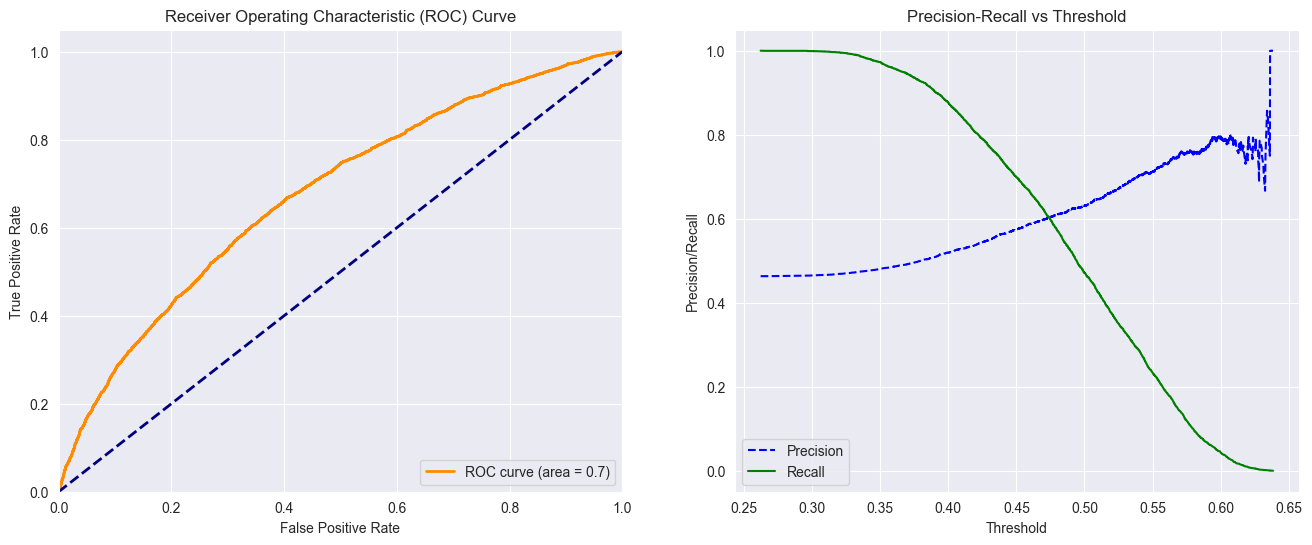

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import recall_score, confusion_matrix, precision_score, precision_recall_curve, roc_curve, roc_auc_score

#Setting hyperparameters
kf = KFold(n_splits=5, random_state=42, shuffle=True)
max_depths = [None] + [i for i in range(2,25)]
min_samples_splits = [i / 100 for i in range(5, 20)]
param_grid = {'max_depth':max_depths,
              'min_samples_split':min_samples_splits}

#Setting features and labels (train and test)
X_train1 = train_model1_scaled[selected_features_rf1]
y_train1 = train_model1_scaled['readmitted_general']
X_test1 = test_model1_scaled[selected_features_rf1]
y_test1 = test_model1_scaled['readmitted_general']

#Initializing the model and cv
rfc1= RandomForestClassifier(random_state=7) 
grid1 = RandomizedSearchCV(rfc1, param_grid, n_iter=20, cv=kf, scoring='roc_auc', n_jobs=-1, random_state=9)

#Fitting the model
grid1.fit(X_train1, y_train1)

#Compute test soft and hard predictions
y_test_prob1 = grid1.predict_proba(X_test1)[:, 1]
y_test_pred1 = grid1.predict(X_test1)

#Compute test metrics
precision_test1 = precision_score(y_test1,y_test_pred1)
recall_test1 = recall_score(y_test1, y_test_pred1)
cm_test1 = confusion_matrix(y_test1, y_test_pred1)
auc_test1 = roc_auc_score(y_test1, y_test_prob1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_test_prob1)

#Compute precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test1, y_test_prob1)

print(f'Best model parameters: {grid1.best_params_}')
print(f'Test AUC: {auc_test1: .1f}')
print(f'Test recall: {recall_test1: .1f}')
print(cm_test1)

# Create a figure for subplots
plt.figure(figsize=(16, 6))  # Adjust overall figure size

# Plot ROC curve on the left (1 row, 2 columns, first subplot)
plt.subplot(1, 2, 1)  # (rows, columns, subplot_index)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_test1:.1f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision/Recall curve on the right (1 row, 2 columns, second subplot)
plt.subplot(1, 2, 2)  # (rows, columns, subplot_index)
plt.plot(thresholds_pr, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)

# Show the combined figure with both subplots
plt.show()

As we have seen the AUC score is pretty decent for the proposed solution. In simple terms, our model has now overpassed a random choice from the population when differentiating between patients who are no readmitted and the ones who are. The precision/recall curve helps to identify how much we would sacrifice in precision metric in order to improve the recall. As we have mentioned, it is more valuable to identify the real readmissions, and the default threshold (.5)  only allows to identify half of them. This is why for final predictions we will set the threshold on .4 so that the model is actually able to identify more than 80% of the true readmissions.

### <30 VS >30 Days Readmission model

As previously mentioned, the training of this submodel faced an additional imbalance challenge, which was tackled by training models with the different types of resampling. For the training of each model the same parameter grid and Cross Validation process were performed. The best performing resampled df was then used to train the final model

In [51]:
X_test2 = test_model2_scaled[selected_features_rf2]
y_test2 = test_model2_scaled['readmitted_type']

#Iterating on all the resamplings and the original without resampling as well
for key, dframe in dfs2.items():
    X_train2 = dframe[selected_features_rf2]
    y_train2 = dframe['readmitted_type']
    
    rfc2= RandomForestClassifier(random_state=17)
    
    grid = RandomizedSearchCV(rfc2, param_grid, n_iter=20, cv=kf, scoring='roc_auc', n_jobs=-1, random_state=20)
    grid.fit(X_train2, y_train2)
    
    y_test_pred2 = grid.predict(X_test2)
    precision_test2 = precision_score(y_test2,y_test_pred2)
    recall_test2 = recall_score(y_test2, y_test_pred2)
    cm_test2 = confusion_matrix(y_test2, y_test_pred2)
    
    print(f'Model with {key}')
    print(grid.best_params_)
    print(grid.best_score_)
    print(f'Test recall = {recall_test2}')
    print(f'Test precision = {precision_test2}')
    print(cm_test2)

/Users/diegoleon/Documents/DLR/Madrid/IE/2nd Term/Machine Learning 2/Group project/diabetes-readmission-prediction/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model with Without Balance
{'min_samples_split': 0.06, 'max_depth': 22}
0.5991362807093378
Test recall = 0.0
Test precision = 0.0
[[5593    0]
 [1752    0]]
Model with Upsampling minority
{'min_samples_split': 0.05, 'max_depth': 12}
0.6388283375937827
Test recall = 0.5308219178082192
Test precision = 0.30642504118616143
[[3488 2105]
 [ 822  930]]
Model with Undersampling majority
{'min_samples_split': 0.05, 'max_depth': 12}
0.5937367724282142
Test recall = 0.5507990867579908
Test precision = 0.29628492477740254
[[3301 2292]
 [ 787  965]]
Model with SMOTE
{'min_samples_split': 0.05, 'max_depth': 12}
0.848644706199831
Test recall = 0.1952054794520548
Test precision = 0.3301158301158301
[[4899  694]
 [1410  342]]


In general terms, the best-performing resample is random oversampling of the minority class. SMOTE technique seems to overfit as the training score looks good but testing metrics are poor. This is why the final second submodel will be trained with the oversample technique.

Best model parameters: {'min_samples_split': 0.05, 'max_depth': None}
Test AUC:  0.6
Test recall:  0.5
[[3467 2126]
 [ 821  931]]


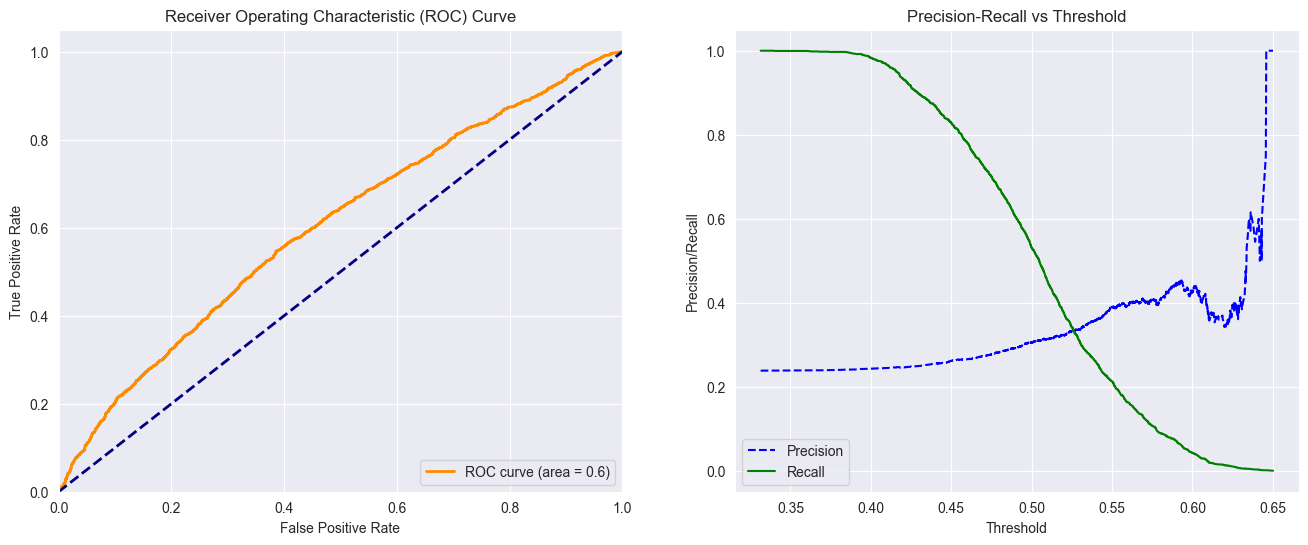

In [52]:
#from sklearn.metrics import precision_recall_curve
X_train2 = upsampled_train_model2[selected_features_rf2]
y_train2 = upsampled_train_model2['readmitted_type']
X_test2 = test_model2_scaled[selected_features_rf2]
y_test2 = test_model2_scaled['readmitted_type'] 

    
#Initializing the model and cv
rfc2= RandomForestClassifier(random_state=17)
grid2 = RandomizedSearchCV(rfc2, param_grid, n_iter=20, cv=kf, scoring='roc_auc', n_jobs=-1, random_state=8)

#Fitting the model
grid2.fit(X_train2, y_train2)

#Compute test soft and hard predictions
y_test_prob2 = grid2.predict_proba(X_test2)[:, 1]
y_test_pred2 = grid2.predict(X_test2)

#Compute test metrics
precision_test2 = precision_score(y_test2,y_test_pred2)
recall_test2 = recall_score(y_test2, y_test_pred2)
cm_test2 = confusion_matrix(y_test2, y_test_pred2)
auc_test2 = roc_auc_score(y_test2, y_test_prob2)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test2, y_test_prob2)

#Compute precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test2, y_test_prob2)

print(f'Best model parameters: {grid2.best_params_}')
print(f'Test AUC: {auc_test2: .1f}')
print(f'Test recall: {recall_test2: .1f}')
print(cm_test2)

# Create a figure for subplots
plt.figure(figsize=(16, 6))  # Adjust overall figure size

# Plot ROC curve on the left (1 row, 2 columns, first subplot)
plt.subplot(1, 2, 1)  # (rows, columns, subplot_index)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_test2:.1f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision/Recall curve on the right (1 row, 2 columns, second subplot)
plt.subplot(1, 2, 2)  # (rows, columns, subplot_index)
plt.plot(thresholds_pr, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)

# Show the combined figure with both subplots
plt.show()

Visually speaking, the second submodel interpretation resembles the first model. However, it seems that with the exisiting data about encounters and patients, the algorithm struggles more to find differences between early and late readmissions. In terms of general performance it does not seem to help us to reach the objectives but it is a fact we need to highlight. In a similar way, to optimize the performance and achieve a better optimization in our metrics, we have decided to change the threshold to 0.45. It does not seem as a significant change, but it actually reaches a test recall of 80% which means that, inside the readmissions, the model would be able to identify 80% of real early ones. Conversely, precision is more sensitive to changes in the threshold, which is the "price" we are paying in order to improve the recall.

# Models bagging (Final Prediction)

Now we are going to test the bagging of both models with unseen data: the original test split that have not been used at all for training

In [53]:
test.shape

(13962, 184)

First we need to transform test set according to the developed Pipeline

In [54]:
final_test_model1 = test.copy()
final_test_model2 = test.copy()

#Applying encodings
impact_encoding_model1(final_test_model1)
impact_encoding_model2(final_test_model2)

#Applying scalers
final_test_model1_scaled = scaler1.transform(final_test_model1[features_model1])
final_test_model2_scaled = scaler2.transform(final_test_model2[features_model2])

#Returning to dfs
final_test_model1_scaled = pd.DataFrame(final_test_model1_scaled, columns=features_model1)
final_test_model2_scaled = pd.DataFrame(final_test_model2_scaled, columns=features_model2)

# Assign the values from the original DataFrames targets
# And explicitly set the data type to match the original DataFrames

for col in no_scale_model1:
    final_test_model1_scaled[col] = final_test_model1[col].values.astype(final_test_model1[col].dtype)
    
for col in no_scale_model2:
    final_test_model2_scaled[col] = final_test_model2[col].values.astype(final_test_model2[col].dtype)


/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/4233579887.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encodings = train_model1_wo_impact_encoding.groupby([i])['readmitted_general'].mean()
/var/folders/_1/jzxxkx2s39l5jxsz34sqhj280000gn/T/ipykernel_7104/4233579887.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encodings = train_model2_wo_impact_encoding.groupby([i])['readmitted_type'].mean()


In [55]:
final_test_model1_scaled.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,readmitted_general
0,0.366846,0.916728,1.183437,0.689303,-0.508262,-1.196562,-0.040188,0.984544,0.494762,0.695701,...,-0.0053,-0.36308,1.049702,-0.658217,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,0
1,0.366846,-1.090836,0.558210,-0.691475,0.447600,0.288149,-0.423811,-1.015699,-0.692545,-0.046379,...,-0.0053,-0.36308,-0.952651,1.519255,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,1
2,0.366846,-1.090836,-0.692245,-0.691475,-0.508262,0.288149,-0.423811,0.984544,1.217471,-0.788459,...,-0.0053,-0.36308,1.049702,-0.658217,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,0
3,0.366846,0.916728,1.183437,0.689303,-0.125917,-1.196562,-0.423811,-1.015699,1.217471,-0.788459,...,-0.0053,-0.36308,-0.952651,-0.658217,2.912186,-0.00918,0.083159,-0.082212,-0.00838,0
4,0.366846,0.916728,1.808665,-0.691475,2.741670,0.288149,1.494302,-1.015699,0.546384,-0.046379,...,-0.0053,-0.36308,1.049702,-0.658217,-0.343385,-0.00918,0.083159,-0.082212,-0.00838,0


In [56]:
final_test_model2_scaled.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,readmitted_type
0,-10.336617,0.898882,1.175061,0.669161,-0.505472,-1.244680,-0.105133,1.026703,0.452747,0.746910,...,-0.005834,-0.394536,1.109740,-0.649702,-0.369907,0.0,0.086063,-0.085862,-0.005834,<NA>
1,-10.336617,-1.112494,0.536647,-0.676904,0.463366,0.250575,-0.486537,-0.973992,-0.742752,-0.008277,...,-0.005834,-0.394536,-0.901112,1.539168,-0.369907,0.0,0.086063,-0.085862,-0.005834,0
2,-10.336617,-1.112494,-0.740180,-0.676904,-0.505472,0.250575,-0.486537,1.026703,1.180443,-0.763465,...,-0.005834,-0.394536,1.109740,-0.649702,-0.369907,0.0,0.086063,-0.085862,-0.005834,<NA>
3,-10.336617,0.898882,1.175061,0.669161,-0.117937,-1.244680,-0.486537,-0.973992,1.180443,-0.763465,...,-0.005834,-0.394536,-0.901112,-0.649702,2.703379,0.0,0.086063,-0.085862,-0.005834,<NA>
4,-10.336617,0.898882,1.813475,-0.676904,2.788577,0.250575,1.420482,-0.973992,0.504726,-0.008277,...,-0.005834,-0.394536,1.109740,-0.649702,-0.369907,0.0,0.086063,-0.085862,-0.005834,<NA>


**Predictions**

In [57]:
#Setting test Xs and ys
X_final_test1 = final_test_model1_scaled[selected_features_rf1]
y_final_test1 = final_test_model1_scaled['readmitted_general']
X_final_test2 = final_test_model2_scaled[selected_features_rf2]
y_final_test2 = final_test_model2_scaled['readmitted_type']

#Setting defined thresholds for hard predictions
threshold1= 0.4
threshold2= 0.45

#Predictions
y_final_test_prob1 = grid1.predict_proba(X_final_test1)[:, 1]
y_final_test_pred1 = (y_final_test_prob1 >= threshold1).astype(int)
y_final_test_prob2 = grid2.predict_proba(X_final_test2)[:, 1]
y_final_test_pred2 = (y_final_test_prob1 >= threshold2).astype(int)

#Adding predictions to test
test['model1_pred'] = y_final_test_pred1
test['model2_pred'] = y_final_test_pred2

#Creating bagged prediction
conditions = [
    test['model1_pred'] == 0,  # Condition for model1_pred == 1
    test['model2_pred'] == 1   # Condition for model2_pred == 1
]

choices = [
    0,  # Choice for model1_pred == 0
    1   # Choice for model2_pred == 1
]
default = 2
test['final_prediction'] = np.select(conditions, choices, default=default)

**Evaluation**

The evaluation consists of initially assessing how the model does in terms of readmission or no readmission and then as whole (the 3 labels)

AUC-ROC score: 0.7
Recall: 0.9


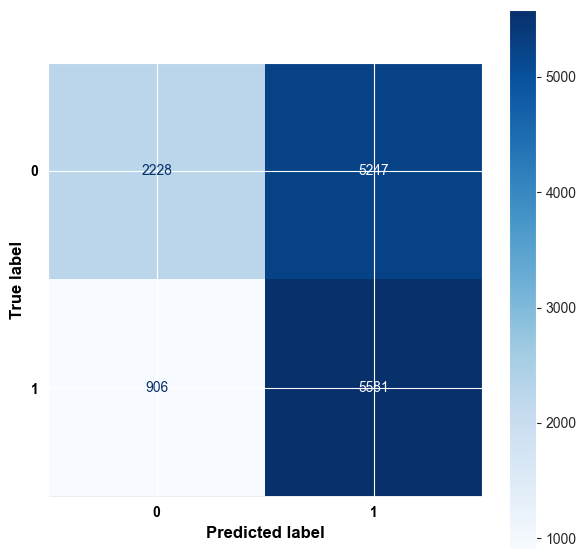

In [58]:
#Readmission vs No readmission performance
from sklearn.metrics import ConfusionMatrixDisplay
print(f'AUC-ROC score: {roc_auc_score(test["readmitted_general"], y_final_test_prob1):.1f}')
print(f'Recall: {recall_score(test["readmitted_general"], test["model1_pred"]):.1f}')
cm = confusion_matrix(test["readmitted_general"], y_final_test_pred1, labels=grid1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid1.classes_)

# Customize the plot
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figure size as needed
disp.plot(cmap='Blues', ax=ax)  # Use a well-defined color palette (e.g., 'Blues', 'viridis')

# Customizing plot
ax.set_xlabel('Predicted label', fontsize=12, weight='bold', color='black')
ax.set_ylabel('True label', fontsize=12, weight='bold', color='black')
ax.set_xticklabels(grid1.classes_, fontsize=10, weight='bold', color='black')
ax.set_yticklabels(grid1.classes_, fontsize=10, weight='bold', color='black')

plt.show()


Final test performance in first submodel seems to be consistent with seen results in training and sub-test. We reached acceptable results in terms of identifying readmissions.

              precision    recall  f1-score   support

           0       0.71      0.30      0.42      7475
           1       0.14      0.70      0.24      1582
           2       0.29      0.19      0.23      4905

    accuracy                           0.30     13962
   macro avg       0.38      0.39      0.30     13962
weighted avg       0.50      0.30      0.33     13962


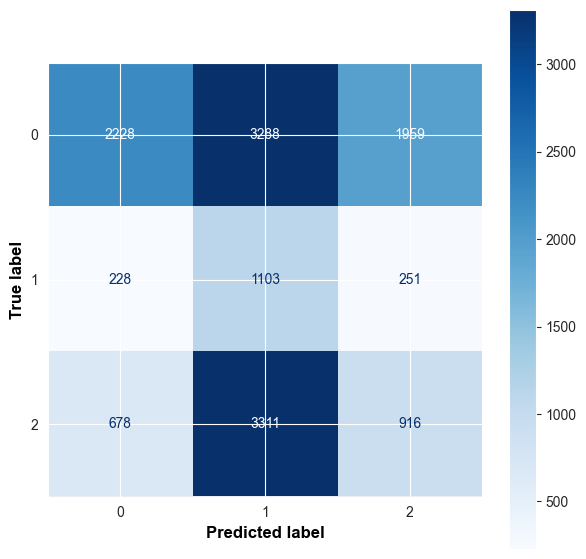

In [59]:
# Overall performance for the three labels
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(test['readmitted'], test['final_prediction']))
cm = confusion_matrix(test['readmitted'], test['final_prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Customize the plot
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figure size as needed
disp.plot(cmap='Blues', ax=ax)  # Use a well-defined color palette (e.g., 'Blues', 'viridis')

# Customizing plot
ax.set_xlabel('Predicted label', fontsize=12, weight='bold', color='black')
ax.set_ylabel('True label', fontsize=12, weight='bold', color='black')

plt.show()


The performance of the overall algorithm fulfills the objectives in terms of predicting readmissions (early ones mainly). This is result of the priority and optimization allocated during solution development. When assessing the model based on how well it distinguished between the 3 classes it is noticeable that it may have improvements. 
It is clear that the deployed algorithms grapple with discerning the type of readmission that a patient could have. Moreover, as a first approach, predicting accurate readmissions will definitely be useful for decreasing related costs and improving the patient care with more personalized preventive actions (as opposed to the current reactive strategy).

# Conclusion

- Our project developed a two-step binary classification algorithm to predict hospital readmissions among diabetic patients, focused on optimizing AUC-ROC scores and recall to accurately identify true positives, especially early readmissions.
- The first submodel successfully differentiates between readmission and no readmission cases, while the second submodel distinguishes between readmissions occurring in less than 30 days versus more than 30 days.
- Individually, both submodels perform well, with a particular strength in identifying actual readmissions and, more specifically, early readmissions (<30 days), aligning with our goal to prioritize early detection.
- The overall model's performance is more effective in predicting early readmissions, with the majority of errors occurring in predicting the >30 days readmissions category. This outcome was anticipated due to the focus on early readmission detection during the model training process.
- Accurately predicting readmissions as a whole can significantly contribute to reducing direct healthcare costs associated with diabetic patient readmissions by enabling hospitals to allocate resources more effectively and implement targeted interventions.
- Moreover, the model facilitates insights into patient care by highlighting the need for more personalized and preventive actions, improving patient outcomes through early intervention and support.

# Recommendations for Future Work

- **Data Collection and Feature Engineering**: Explore the collection of additional features, such as time to readmission, patient lifestyle factors, and more detailed medical history, to improve the model's ability to distinguish between different readmission time frames.
- **Model Refinement**: Investigate advanced machine learning techniques and algorithms that may offer improved performance, especially for predicting >30 days readmissions.
- **Focus on >30 Days Readmissions**: Given the current model's challenges in accurately predicting >30 days readmissions, future efforts could specifically target enhancing performance in this area through targeted feature selection and algorithm adjustments.
- **Integration with Healthcare Systems**: Work on developing a seamless integration framework for the model within existing healthcare IT ecosystems to facilitate real-time predictions and interventions.
- **Patient-Centric Approaches**: Incorporate patient feedback and outcomes into the model to refine its predictive capabilities further and ensure it addresses the most relevant factors affecting readmission risks.
- **Continuous Monitoring and Updating**: Establish a mechanism for continuous model evaluation and updating based on new data and evolving healthcare practices to maintain its relevance and effectiveness over time.
